## 1. Import Libraries

In [106]:
from os.path import join
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
pd.options.mode.chained_assignment = None

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor,DMatrix, cv
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
import math

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, mean_squared_error, make_scorer, mean_absolute_error, mean_absolute_percentage_error

## 2. Merge all trip_metrics

In [107]:
# trip_metrics_1 = pd.read_csv("../Yeni dosyalar/trip_metrics_1-6.csv")
# trip_metrics_2 = pd.read_csv("../Yeni dosyalar/trip_metrics_7-12.csv")
# trip_metrics_3 = pd.read_csv("../Yeni dosyalar/trip_metrics_13-18.csv")
# trip_metrics_4 = pd.read_csv("../Yeni dosyalar/trip_metrics_19-24.csv")
# trip_metrics_5 = pd.read_csv("../Yeni dosyalar/trip_metrics_25-30.csv")

# df_list = [trip_metrics_1,trip_metrics_2,trip_metrics_3,trip_metrics_4,trip_metrics_5]
# trips_merged = pd.concat(df_list)
# # trips_merged.to_csv('trips_merged.csv',index=False)



In [108]:
# # if you have all data just use this method
trips_merged = pd.read_csv("trips_merged.csv")
trips_merged

,ID,Energy_Consumption_kWh,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,City_Name,Max_Speed,Min_Speed,...,Max_Altitude-diff,Min_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Characteristic_Acceleration,Kinetic_Intensity,Traffic_Category_Mean
0,vehicle_106_2013-01-02_trip_1,49.808978,2013-01-02 17:03:03,2013-01-02 23:01:16,21493,2.360999,14.095821,New York,85.29502,0.0,...,141.0,-36.0,186.0,0.0,31.439192,-1.630595,2543.015725,0.008343,0.000067,1.987904
1,vehicle_106_2013-01-02_trip_2,0.046400,2013-01-03 00:32:29,2013-01-03 00:33:34,65,0.000000,0.000000,New York,0.00000,0.0,...,0.0,-1.0,30.0,29.0,29.060606,4.000000,2499.651515,-inf,NaN,1.000000
2,vehicle_106_2013-01-02_trip_3,17.837048,2013-01-03 04:38:03,2013-01-03 06:59:37,8494,7.062909,16.664542,New York,48.28020,0.0,...,28.0,-20.0,59.0,0.0,16.777634,1.608240,2530.378340,0.006475,0.000172,2.689935
3,vehicle_106_2013-01-03_trip_1,11.895772,2013-01-03 07:00:39,2013-01-03 08:30:55,5416,5.218145,7.850409,New York,64.37360,0.0,...,38.0,-5.0,92.0,2.0,43.463725,1.625696,2532.115193,-0.057436,-0.000621,3.000000
4,vehicle_106_2013-01-03_trip_2,0.147490,2013-01-03 09:24:15,2013-01-03 09:26:51,156,0.102506,0.004442,New York,3.21868,0.0,...,1.0,-1.0,29.0,25.0,26.573248,2.235669,2495.414013,-2.206256,-9.538746,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61352,vehicle_441_2015-01-10_trip_6,3.652813,2015-01-10 22:13:18,2015-01-10 22:24:12,654,19.997585,3.632895,New Jersey,56.32690,0.0,...,14.0,-6.0,68.0,8.0,33.638168,-8.116031,NaN,-0.105205,-0.000809,1.000000
61353,vehicle_441_2015-01-10_trip_7,0.118821,2015-01-10 22:55:34,2015-01-10 22:57:07,93,1.523737,0.039363,New Jersey,12.87472,0.0,...,23.0,-5.0,44.0,15.0,23.627660,-8.000000,NaN,0.746890,0.197058,1.000000
61354,vehicle_441_2015-01-10_trip_8,17.988823,2015-01-10 23:19:55,2015-01-11 00:05:32,2737,26.445371,20.105828,New Jersey,74.02964,0.0,...,2.0,-9.0,54.0,1.0,27.613587,-7.542001,NaN,0.011211,0.000064,1.000000
61355,vehicle_441_2015-01-11_trip_1,0.299584,2015-01-12 04:58:17,2015-01-12 04:59:53,96,9.938089,0.265016,New Jersey,22.53076,0.0,...,1.0,-1.0,41.0,31.0,36.731959,2.721649,NaN,-0.110937,-0.004504,1.000000


## 3. Feature Enginnering

In [109]:
trips_merged = trips_merged.rename(columns={"City_Name": "State_Name"})

In [110]:
#TAKING START HOUR AND END HOUR
trips_merged['Start_Time'] = pd.to_datetime(trips_merged['Start_Time'])
trips_merged['End_Time'] = pd.to_datetime(trips_merged['End_Time'])

trips_merged['Start_Hour'] = trips_merged['Start_Time'].dt.hour
trips_merged['End_Hour'] = trips_merged['End_Time'].dt.hour

In [111]:
trips_merged['Season'] = trips_merged['Start_Time'].dt.month.apply(
                        lambda month: 'Spring' if 3 <= month <= 5 
                        else 'Summer' if 6 <= month <= 8       
                        else 'Fall' if 9 <= month <= 11      
                        else 'Winter')    

In [112]:
# handling the energy consumption values by dropping rows with value 0 and takinbg absolute value to remove negative consumptions
ENERGY_NAME = 'Energy_Consumption_kWh/km'

trips_merged['Energy_Consumption_kWh'] = trips_merged['Energy_Consumption_kWh'] / trips_merged['Total_Distance_km']

trips_merged = trips_merged.rename(columns={"Energy_Consumption_kWh": ENERGY_NAME})
trips_merged = trips_merged[trips_merged[ENERGY_NAME] >=-50]

In [113]:
state_dict = ['内蒙古自治区','Алматы облысы','Pays de la Loire','Comunitat Valenciana','Naâma ⵏⵄⴰⵎⴰ النعامة',
              'Castilla-La Mancha', 'Aragón', '河南省', 'Centre-Val de Loire','Occitanie', 'Salzburg', None, 'Kansas', 'Nevada','Colorado','Michigan','Nebraska','Wisconsin']
trips_merged['State_Name']  = trips_merged['State_Name'].replace(state_dict, 'Unknown')
trips_merged['State_Name'].unique()

array(['New York', 'Unknown', 'Indiana', 'Missouri', 'California',
       'Washington', 'Arizona', 'Maryland', 'District of Columbia',
       'New Jersey', 'Illinois', 'Virginia'], dtype=object)

## 4. Splitting the data to train test

In [114]:
trips_merged = trips_merged.dropna()

In [115]:
trips_merged = trips_merged[trips_merged['Total_Distance_km'] >= 5]
trips_merged = trips_merged[trips_merged['Total_Distance_km'] < 75]

In [116]:
cols_to_keep = ['Duration_s', 'Average_Speed_kmh', 'Max_Speed','Start_Hour','End_Hour',
       'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude','Season','State_Season',
       'Min_Altitude', 'GPS_Altitude_Mean', 'Average_Ambient_Temperature',
       'Average_air', 'Kinetic_Intensity', 'Traffic_Category_Mean',
       'State_Name','Total_Distance_km']

In [117]:
trips_merged['State_Season'] = trips_merged['State_Name'] +'-' + trips_merged['Season'] #for stratification in terms of season and state
X = trips_merged[cols_to_keep]
y = trips_merged[ENERGY_NAME]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55, stratify=X['State_Season'])
X_train = X_train.drop(['State_Season'], axis=1)
X_test = X_test.drop(['State_Season'], axis=1)
X = X.drop(['State_Season'], axis=1)

## Explatory Data Analysis

In [118]:
#merging energy consumption to another df to visualzie the train data better. This df_train will not be used in models
df_train = X_train.copy()
df_train[ENERGY_NAME] = y_train

<Axes: >

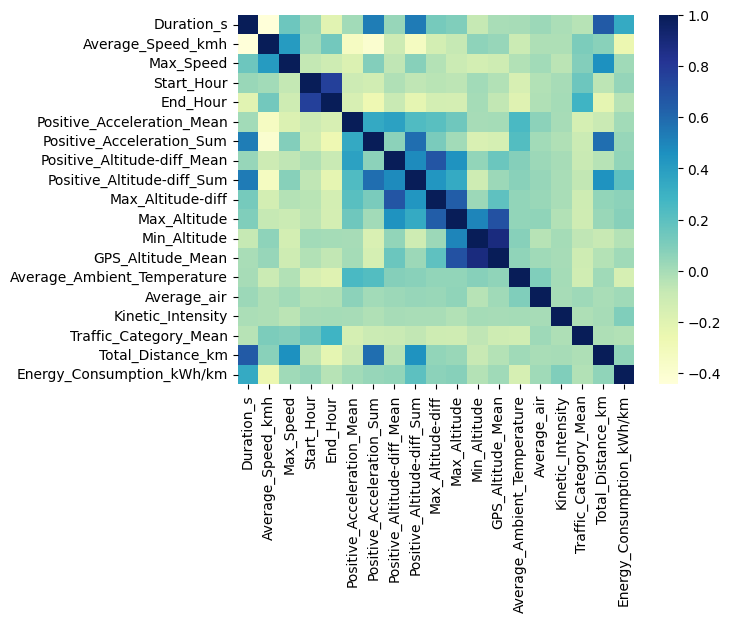

In [119]:
sns.heatmap(df_train.drop(columns=["State_Name",'Season']).corr(), cmap="YlGnBu")

<Axes: >

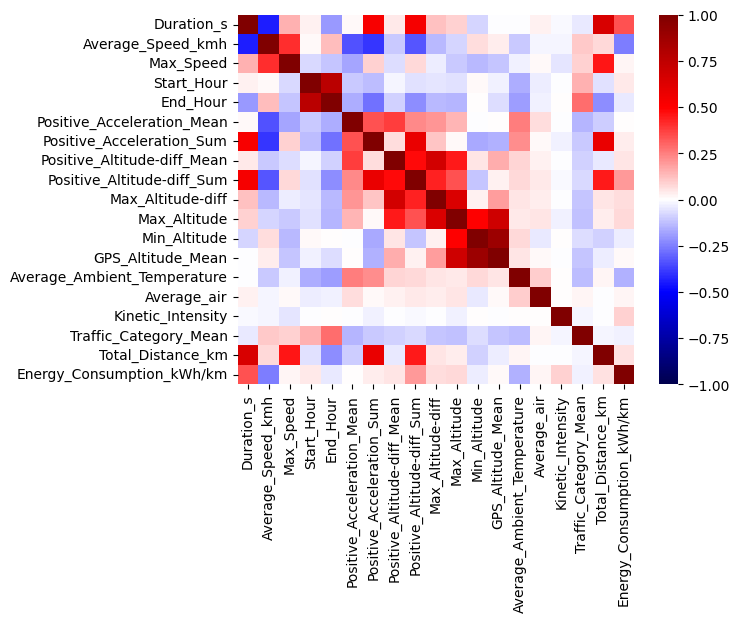

In [120]:
vmin = -1
vmax = 1
cmap = sns.color_palette(["red", "white", "green"])
sns.heatmap(df_train.drop(columns=["State_Name",'Season']).corr(), cmap = "seismic" ,center=0,  fmt=".1f", vmin=vmin, vmax=vmax,)

<Axes: >

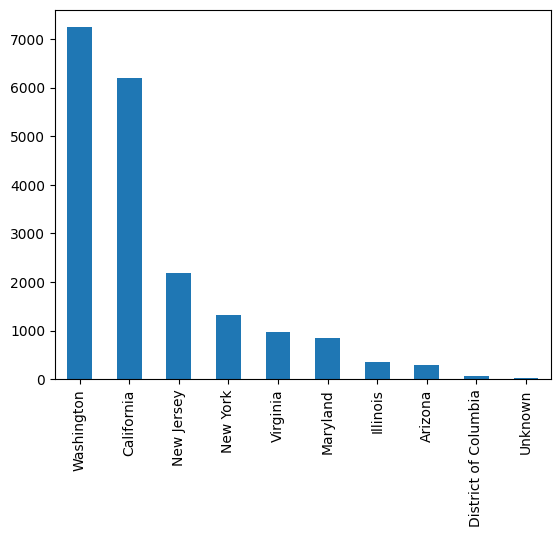

In [121]:
df_train['State_Name'].value_counts().head(10).plot.bar()

<Axes: >

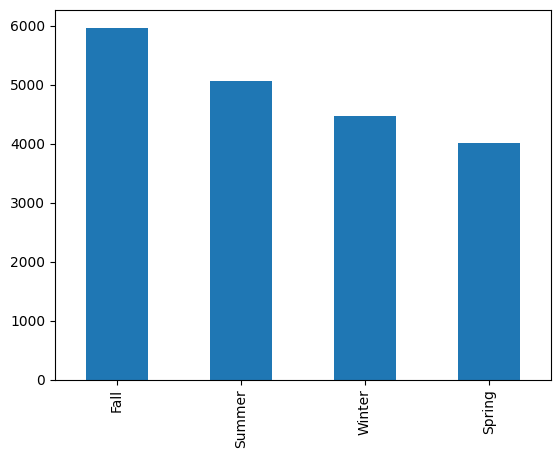

In [122]:
df_train['Season'].value_counts().plot.bar()

<Axes: >

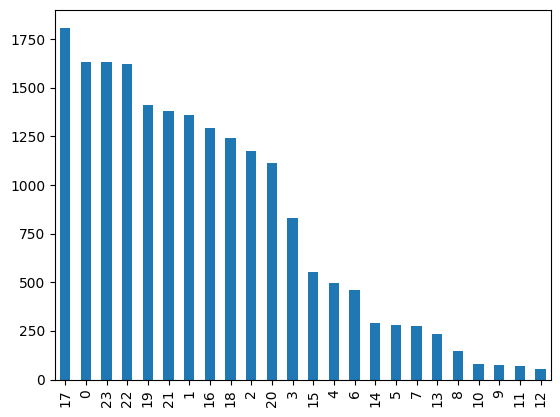

In [123]:
df_train['Start_Hour'].value_counts().plot.bar()

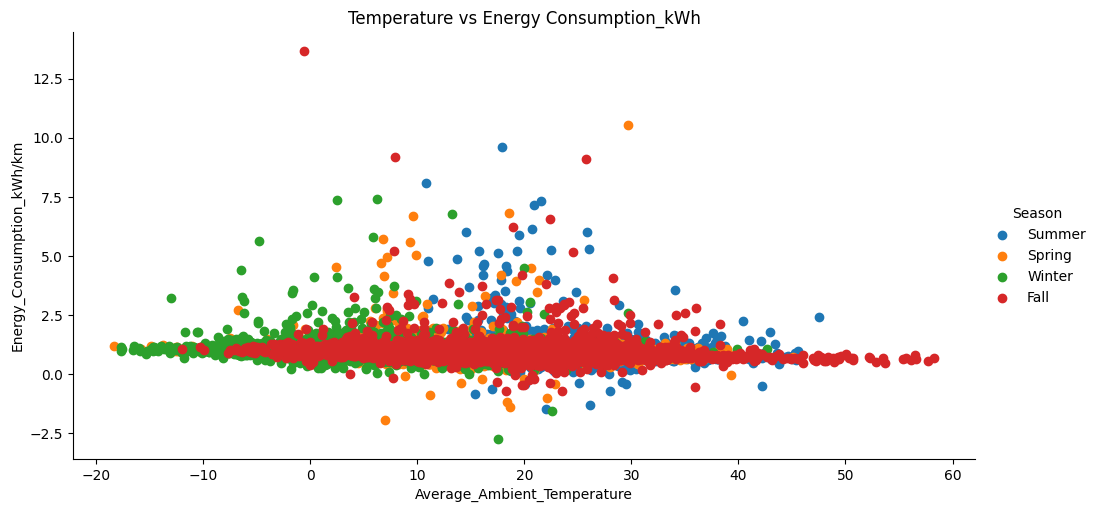

In [124]:
sns.FacetGrid(df_train, hue="Season", height=5, aspect=2) \
   .map(plt.scatter, "Average_Ambient_Temperature", ENERGY_NAME) \
   .add_legend().set(title='Temperature vs Energy Consumption_kWh')

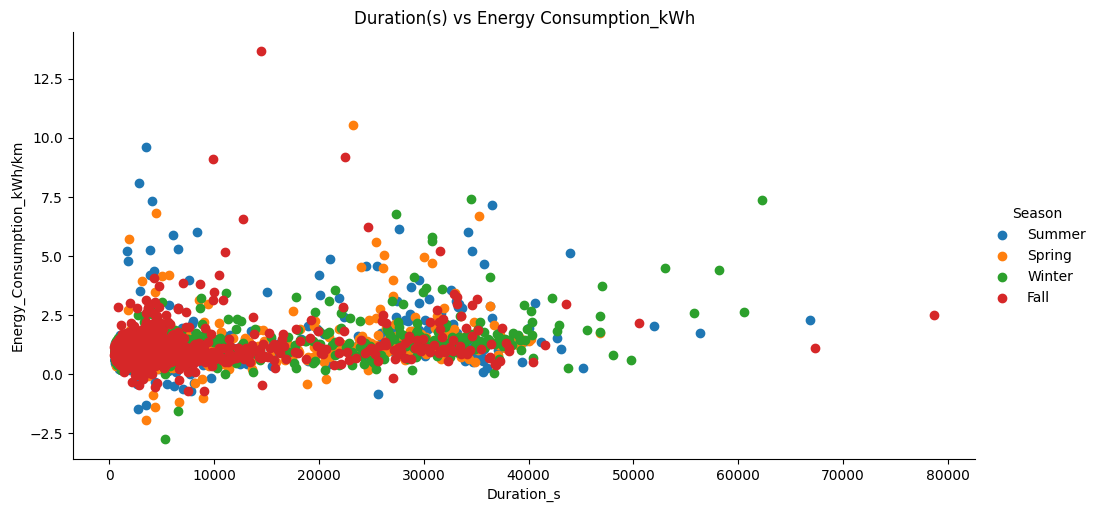

In [125]:
sns.FacetGrid(df_train, hue="Season", height=5, aspect=2) \
   .map(plt.scatter, "Duration_s",ENERGY_NAME) \
   .add_legend().set(title='Duration(s) vs Energy Consumption_kWh')

In [126]:
df_train.columns

Index(['Duration_s', 'Average_Speed_kmh', 'Max_Speed', 'Start_Hour',
       'End_Hour', 'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude', 'Season', 'Min_Altitude',
       'GPS_Altitude_Mean', 'Average_Ambient_Temperature', 'Average_air',
       'Kinetic_Intensity', 'Traffic_Category_Mean', 'State_Name',
       'Total_Distance_km', 'Energy_Consumption_kWh/km'],
      dtype='object')

 ## 5. BaseLine Classifier

### 5.1 Baseline for all model

In [127]:
#This part was not in the feature engineering part as we have to startify our train test split according to city names so this part should come after that
X_train = pd.get_dummies(X_train, columns=['State_Name','Season'], prefix="",prefix_sep="") 
X_test = pd.get_dummies(X_test, columns=['State_Name','Season'], prefix="",prefix_sep="") 

X = pd.get_dummies(X, columns=['State_Name','Season'], prefix="",prefix_sep="") 
# df_train = pd.get_dummies(df_train, columns=['State_Name'], prefix="",prefix_sep="") 

In [128]:
def custom_metric(actual_values,predictions):
    if(actual_values == 0):
        return 0
    error = abs(predictions - actual_values) / actual_values
    if error <= 0.1:
        return 1
    else:
        return 0

In [129]:
def custom_accuracy(actual_values,predictions):
    test = pd.DataFrame(actual_values)
    test['predictions'] = predictions
    test['class'] = test.apply(lambda row: custom_metric(row[ENERGY_NAME],row['predictions']), axis=1)
    accuracy = 0
    if(test.shape[0] > test['class'].value_counts()[0]):
        accuracy = test['class'].value_counts()[1] / test.shape[0]
        
    return accuracy

In [130]:
consumption_mean = y_train.mean()

df_temp = pd.DataFrame(y)
df_temp['baseline'] = consumption_mean

accuracy = custom_accuracy(df_temp[ENERGY_NAME],df_temp['baseline'])
print('Baseline Accuracy is:',accuracy)


Baseline Accuracy is: 0.3960067237915625


### 5.2 Baseline for every State

In [132]:
State_list = df_train['State_Name'].unique()

for x in State_list:
    temp_df = df_train[df_train['State_Name'] == x]
    baseline = temp_df[ENERGY_NAME].mean() 
    temp_df['baseline'] = baseline
    df_temp['baseline'] = baseline
    accuracy_local = custom_accuracy(temp_df[ENERGY_NAME],temp_df['baseline'])
    accuracy_general = custom_accuracy(df_temp[ENERGY_NAME],df_temp['baseline'])
    
    print('Baseline Accuracy for',x, 'is:',"%.3f" % accuracy_local)
    print('Baseline Accuracy using',x, 'baseline to predict all data','is:',"%.3f" % accuracy_general)

Baseline Accuracy for New York is: 0.276
Baseline Accuracy using New York baseline to predict all data is: 0.178
Baseline Accuracy for Washington is: 0.389
Baseline Accuracy using Washington baseline to predict all data is: 0.373
Baseline Accuracy for California is: 0.346
Baseline Accuracy using California baseline to predict all data is: 0.407
Baseline Accuracy for New Jersey is: 0.603
Baseline Accuracy using New Jersey baseline to predict all data is: 0.407
Baseline Accuracy for Virginia is: 0.555
Baseline Accuracy using Virginia baseline to predict all data is: 0.396
Baseline Accuracy for Arizona is: 0.536
Baseline Accuracy using Arizona baseline to predict all data is: 0.187
Baseline Accuracy for Maryland is: 0.553
Baseline Accuracy using Maryland baseline to predict all data is: 0.397
Baseline Accuracy for Illinois is: 0.180
Baseline Accuracy using Illinois baseline to predict all data is: 0.408
Baseline Accuracy for District of Columbia is: 0.400
Baseline Accuracy using District 

## 6. Applying Machine Learning Models

In [119]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
custom_acc = make_scorer(custom_accuracy, greater_is_better=True)

### 6.1. Random Forest 

#### 6.1.1 Random Forest train test split

In [276]:
clf = RandomForestRegressor(n_estimators=700)
clf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=700)

In [281]:
predictions = clf.predict(X_test)
mse_s = mean_squared_error(y_test, predictions)
print('Mse:',mse_s)
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()

accuracy = custom_accuracy(df_temp[ENERGY_NAME],df_temp['predictions'])
print('Accuracy:',accuracy)

'''
error %15, without /km,  trips distance > 5 and < 75
Mse: 55.570051273678004
Accuracy: 0.8542734166837467

error %10, without /km  trips distance > 5 and < 75
Mse: 55.570051273678004
Accuracy: 0.7394957983193278

error %10, with /km ,  trips distance > 5 and < 75
Mse: 0.1622583614221461
Accuracy: 0.7378561180569789

error %15, with /km , w trips distance > 5 and < 75
Mse: 0.1622583614221461
Accuracy: 0.8550932568149211
'''

Mse: 0.1622583614221461
Accuracy: 0.7378561180569789


'\nerror %15, without /km,  trips distance > 5 and < 75\nMse: 55.570051273678004\nAccuracy: 0.8542734166837467\n\nerror %10, without /km  trips distance > 5 and < 75\nMse: 55.570051273678004\nAccuracy: 0.7394957983193278\n\nerror %10, with /km ,  trips distance > 5 and < 75\nMse: 0.16015310259187038\nAccuracy: 0.7634761221561795\n\nerror %15, with /km , w trips distance > 5 and < 75\nMse: 0.1622583614221461\nAccuracy: 0.8550932568149211\n'

<Axes: >

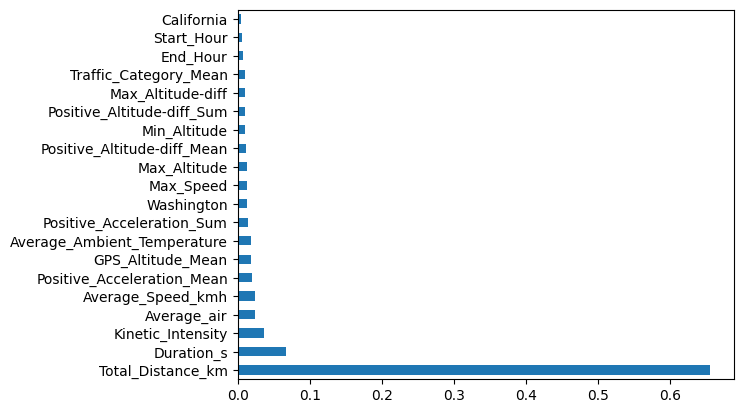

In [94]:
(pd.Series(clf.feature_importances_, index=X_train.columns)
   .nlargest(20)
   .plot(kind='barh')) 

#### 6.1.2 Random Forest Stratified Kfold

In [176]:
#CUSTOM ACCURACY
clf = RandomForestRegressor(n_estimators=700)
cv  = KFold(shuffle=True, random_state=42)

scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=custom_acc)
print(scores)
print(f'Scores mean: {np.mean(scores):.4f}')

[0.57391813 0.57883041 0.56982456 0.56666667 0.57777778]
Scores mean: 0.5734


In [ ]:
#MEAN SQUARED ERROR
clf = RandomForestRegressor(n_estimators=700)
cv  = KFold(shuffle=True, random_state=42)

scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=mse)
print(scores)
print(f'Scores mean: {np.mean(scores):.4f}')

### 6.2 XGBoost

#### 6.1.1 XGBoost train test split

In [315]:
params = {
    'learning_rate': [0.1]
    # 'max_depth': [9],
    # 'subsample':[0.9],
    # 'colsample_bytree':[0.9],
    # 'gamma':[0.3]
}

# create an XGB Boost instance
xgb_reg = XGBRegressor(n_estimators = 700)
xgb_reg.fit(X_train, y_train)

# searching the model
# XGB_Model= GridSearchCV(estimator = xgb_reg, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=mse)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [319]:
predictions = xgb_reg.predict(X_test)
mse_s = mean_squared_error(y_test, predictions)
print('Mse:',mse_s)
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()

accuracy = custom_accuracy(df_temp[ENERGY_NAME],df_temp['predictions'])
print('Accuracy:',accuracy)

Mse: 61.914295821780236
Accuracy: 0.6974789915966386


In [ ]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row[ENERGY_NAME],row['predictions']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Accuracy is:',accuracy)

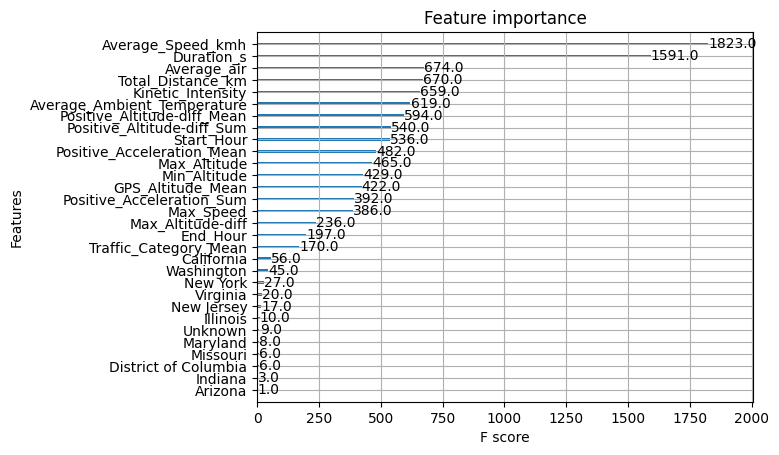

In [65]:
from xgboost import plot_importance
plot_importance(XGB_Model.best_estimator_)
plt.show()

#### 6.1.2 XGBoost Kfold

In [236]:
xgb_reg = XGBRegressor(learning_rate =0.1,
 n_estimators=400,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

# n_estimators: 1000=0.47, 900=0.4657, 800=0.4575,700= , 600= , 500= , 400=

In [237]:
cv  = KFold(shuffle=True, random_state=42)

scores = cross_val_score(xgb_reg, X_train, y_train, cv=cv, scoring=custom_acc)
print(scores)
print(f'Scores mean: {np.mean(scores):.4f}')

[0.41883041 0.4194152  0.41204678 0.40292398 0.41473684]
Scores mean: 0.4136


### 6.4 Extra Trees

#### 6.1.1 Extra Trees Train Test Split

In [611]:
clf = ExtraTreesRegressor(n_estimators= 700)
# parameters = {
#     'n_estimators': [700],
#     # 'max_depth': [34],
#     # 'min_samples_split': [ 21]
# }
# clf = GridSearchCV(clf, parameters, cv=5, verbose=True, scoring=mse)
clf.fit(X_train, y_train)
# clf.best_params_

ExtraTreesRegressor(n_estimators=700)

In [643]:

predictions = clf.predict(X_test)
mse_s = mean_squared_error(y_test, predictions)
print('Mse:',mse_s)
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()

accuracy = custom_accuracy(df_temp[ENERGY_NAME],df_temp['predictions'])
print('Accuracy:',accuracy)
'''
Last week without season %10 without /km
Mse: 52.52781078796234
Accuracy: 0.5994573353293413

error %10, without /km
Mse: 72.30143208431585
Accuracy: 0.6057260479041916

 error %10
Mse: 12701.484965328966
Accuracy: 0.593001497005988

error %15, without /km
Mse: 71.3070574663078
Accuracy: 0.7295097305389222

error %15, without /km,  trips distance > 5 and < 75
Mse: 54.72494776524199
Accuracy: 0.8637015781922525

error %10, without /km  trips distance > 5 and < 75
Mse: 54.72494776524199
Accuracy: 0.763271162123386

error %10, with /km ,  trips distance > 5 and < 75
Mse: 0.16015310259187038
Accuracy: 0.7634761221561795

error %15, with /km , w trips distance > 5 and < 75
Mse: 0.16015310259187038
Accuracy: 0.867595818815331


'''

Mse: 54.72494776524199
Accuracy: 0.763271162123386


'\nLast week without season %10 without /km\nMse: 52.52781078796234\nAccuracy: 0.5994573353293413\n\nerror %10, without /km\nMse: 72.30143208431585\nAccuracy: 0.6057260479041916\n\n error %10\nMse: 12701.484965328966\nAccuracy: 0.593001497005988\n\nerror %15, without /km\nMse: 71.3070574663078\nAccuracy: 0.7295097305389222\n\nerror %15, without /km,  trips distance > 5 and < 75\nMse: 54.72494776524199\nAccuracy: 0.8637015781922525\n\nerror %10, without /km  trips distance > 5 and < 75\nMse: 54.72494776524199\nAccuracy: 0.8637015781922525\n\nerror %10, with /km ,  trips distance > 5 and < 75\nMse: 0.16015310259187038\nAccuracy: 0.7634761221561795\n\nerror %15, with /km , w trips distance > 5 and < 75\nMse: 0.16015310259187038\nAccuracy: 0.867595818815331\n\n\n'

<Axes: >

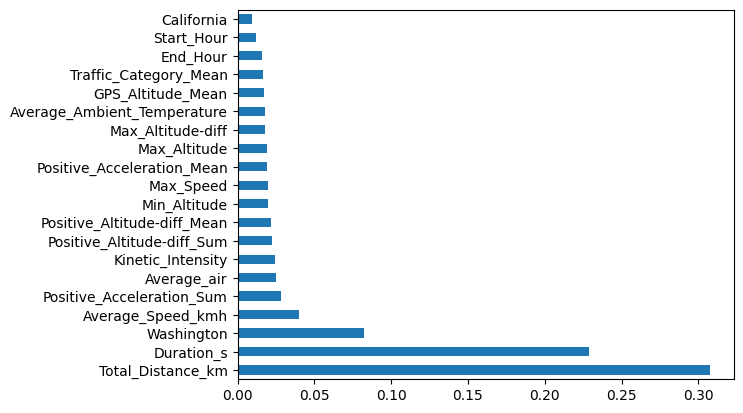

In [644]:
(pd.Series(clf.feature_importances_, index=X_test.columns)
   .nlargest(20)
   .plot(kind='barh')) 

#### 6.1.2 Extra Trees Stratified Kfold

In [120]:
#CUSTOM ACCURACY
clf = ExtraTreesRegressor(n_estimators=700)
cv  = KFold(shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv, scoring=custom_acc)
print(scores)
print(f'Scores mean: {np.mean(scores):.4f}')

'''n_estimator 700: 0.5931      '''

[0.76347612 0.76096761 0.75563756 0.75256253 0.75440754]
Scores mean: 0.7574


'n_estimator 700: 0.5931      '